In [1]:
# Import libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Download the data trasforming 'g' -> 1 and 'h' -> 0
destination = '/content/drive/MyDrive/MAGIC ML/data'
data = pd.read_csv(destination + '/telescope_data.csv')
data['class'] = data['class'].map({'g': 1, 'h': 0})
data = data.drop(['Unnamed: 0'], axis=1)
data.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


In [4]:
# Drop duplicate rows and data with zero width
data = data.drop_duplicates().reset_index(drop=True)
data = data[data["fWidth"] != 0].reset_index(drop=True)

In [5]:
# Target distribution
data['class'].value_counts()

,count
class,
1,12254
0,6553


## Image Creation


Generazione immagini misurando gli assi dell'elisse e crenado uno sfondo di intensità proporzionale all'intensità totale più due picchi aggiuntivi relativi ai pixel con maggior luminosità

In [6]:
# Install required packages for Keras model tuning and scikit-learn compatibility
!pip install scikeras
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [7]:
# Import libraries need for image creation and CNN
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_score, recall_score

In [8]:
# Generates the image from the tabul data with elliptical background and main peaks for the given event

def create_event_image_with_peaks(event, img_size):
    # Extract parameters from the event data
    fLength = event['fLength']
    fWidth = event['fWidth']
    fSize_log = event['fSize']
    fDist = event['fDist']
    fAlpha = event['fAlpha']
    fConc = event['fConc']
    fConc1 = event['fConc1']
    fAsym = event['fAsym']

    # Convert the logarithmic intensity to actual intensity value and from there we calculated the peaks and background intensity
    total_intensity = 10 ** fSize_log
    main_peak = total_intensity * fConc1 # Main peak intensity
    second_peak = total_intensity * (fConc - fConc1) # Second peak intensity
    background = total_intensity - (main_peak + second_peak) # Background intensity

    # Calculate ellipse semi-axes and angle
    a = fLength / 2
    b = fWidth / 2
    alpha_rad = np.deg2rad(fAlpha)

    # Calculate ellipse center position scaling it by a factor 10 to make it eneter in the pixel image
    x0 = img_size / 2 + fDist * np.cos(alpha_rad) / 10
    y0 = img_size / 2 + fDist * np.sin(alpha_rad) / 10

    # Create a grid of pixel coordinates for the image
    Y, X = np.meshgrid(np.arange(img_size), np.arange(img_size))
    Xc = X - x0 # Shift coordinates by the center
    Yc = Y - y0

    # Rotation to adapt the coordinates to the ellipse orientation
    X_rot = Xc * np.cos(alpha_rad) + Yc * np.sin(alpha_rad)
    Y_rot = -Xc * np.sin(alpha_rad) + Yc * np.cos(alpha_rad)

    # Create the image with the elliptical background thanks to the application of esponential function theat reduce the intensity moving away from the center
    image = np.zeros((img_size, img_size))
    image = background * np.exp(-((X_rot / a)**2 + (Y_rot / b)**2))

    # Apply Gaussian filter for blurring the background
    image = gaussian_filter(image, sigma=3)

    # Compute the position of the peaks symmetrical along the major axis using a gaussian function to shape their intensity
    # Compute the position of the main peak
    x_main = x0 + (fAsym / 10) * np.cos(alpha_rad)
    y_main = y0 + (fAsym / 10) * np.sin(alpha_rad)

    # Add the main peak to the image
    image += main_peak * np.exp(-((X - x_main)**2 + (Y - y_main)**2) / (2 * 1.5**2))

    # Compute the position of the second peak
    x_second = x0 - (fAsym / 10) * np.cos(alpha_rad)
    y_second = y0 - (fAsym / 10) * np.sin(alpha_rad)

    # Add the second peak to the image
    image += second_peak * np.exp(-((X - x_second)**2 + (Y - y_second)**2) / (2 * 1.5**2))

    return image

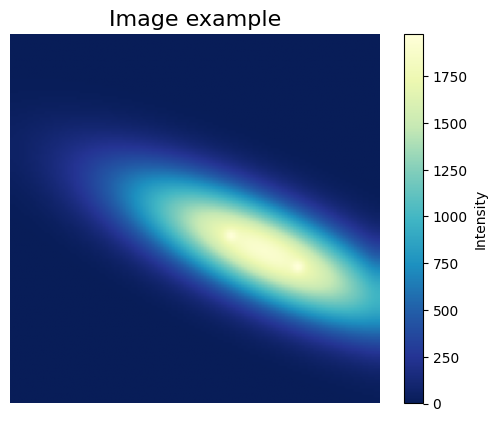

In [9]:
# Select an event to create and plot the new image we will be working with
sample_event = data.iloc[18002]
image = create_event_image_with_peaks(sample_event, 128)

plt.imshow(image, cmap='YlGnBu_r')
plt.title("Image example", fontsize=16)
plt.colorbar(label='Intensity')
plt.axis('off')

#plt.savefig("/content/drive/MyDrive/MAGIC ML/immagini/artificial_image.png", dpi=300)
plt.show()

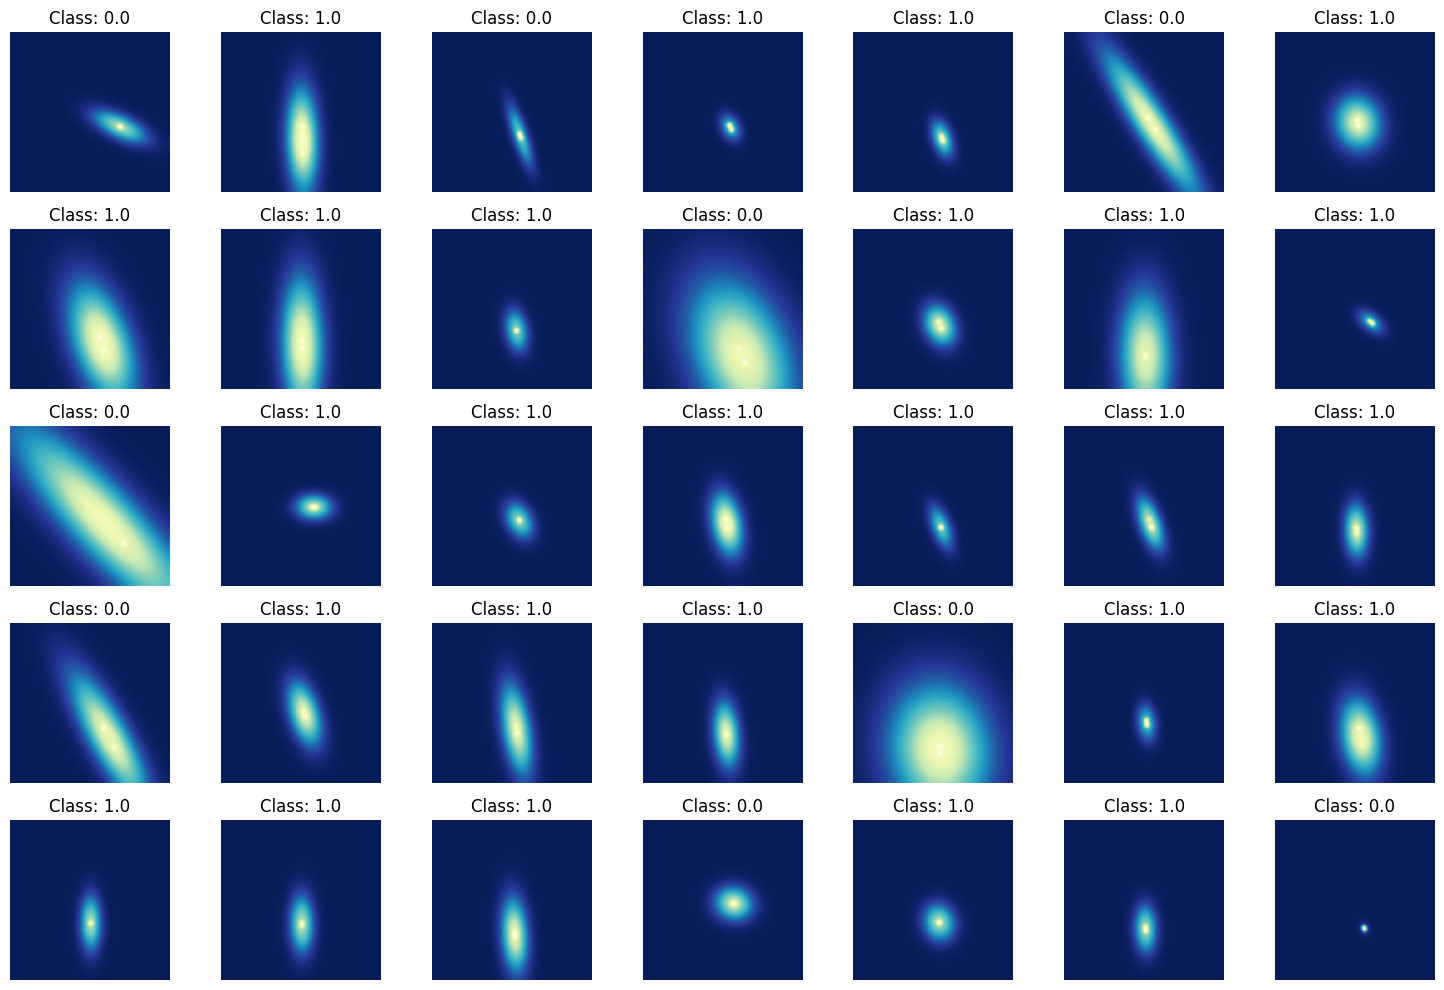

In [ ]:
# Visual analysis of how the images turn out by randomly plotting 35 of them
n_rows = 5
n_cols = 7
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

# Event selection
sample_indices = data.sample(n=n_rows * n_cols).index

for ax, idx in zip(axes.flat, sample_indices):
    event = data.loc[idx]
    image = create_event_image_with_peaks(event, 128)
    ax.imshow(image, cmap='YlGnBu_r')
    ax.set_title(f"Class: {event['class']}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# CNN

In [10]:
# Parametrers setup
img_size = 128
X = [] # List to hold the image data
y = []  # List to hold the class labels (gamma or hadron)

# Iterate over the events in the dataset and generate images
for idx, row in tqdm(data.iterrows(), total=len(data)):
    img = create_event_image_with_peaks(row, img_size)
    X.append(img)
    y.append(row['class'])

# Convert lists to NumPy arrays for easier manipulation in the model
X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.int64)

# Normalize each image by its maximum pixel value
X = np.array([img / (img.max() if img.max() > 0 else 1.0) for img in X])
X = X[..., np.newaxis]  # Add a new axis to the images to match the expected input format for CNN

# Split the data into training and testing sets (stratify preserv class distribution and shuffle is useful to mix the dataset)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

# Early Stopping callback
es_callback = keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True)

# Due to the fact that the different classes have a different number of elements, we consider
#  different weights for each class. We compute those weighs using the sklearn.utils.class_weight
class_weights = compute_class_weight( class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

100%|██████████| 18807/18807 [00:38<00:00, 488.13it/s]


In [11]:
# Create a convolutional neural network using a hyperparameter space 'hp' in which we will
# search the bet set of parameters (number of neurons, dropout rate for the dropout layer and best learning rate)

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=(128, 128, 1)))

    model.add(layers.Conv2D(
        filters=hp.Int("filters_1", 64, 128, step=32),
        kernel_size=(3, 3)))

    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(
        filters=hp.Int("filters_2", 32, 96, step=32),
        kernel_size=(3, 3)))

    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(hp.Int("dense_units", 32, 96, step=32), activation="relu"))

    if hp.Boolean("use_dropout"):
        model.add(layers.Dropout(rate=hp.Float("dropout_rate", 0.1, 0.3, step=0.1)))

    #Having a binary classification problem we use 'sigmoid' as activation factor
    model.add(layers.Dense(1, activation="sigmoid"))

    # Compile the model using the Adam optimizer and the binary crossentropy
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-3, 5e-4, 1e-4])),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name='auc', curve='ROC')]
    )
    return model

In [12]:
#Directory where to save the tuner performances
directory = "/content/drive/MyDrive/MAGIC ML/my_tuner"
project_name = "magic_cnn_v3"

# Define a Hyperband tuner for optimizing the CNN model's hyperparameters using as objective the AUC value
tuner = kt.Hyperband(
    build_model,
    objective="val_auc",
    max_epochs=50,
    factor=3,
    directory=directory,
    project_name=project_name,
)

# Perform the hyperparameter search using validation split and class weights
tuner.search(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    verbose=1,
    callbacks=[es_callback],
    class_weight=class_weights,
)

# Retrieve the best model found by the tuner
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Predict probabilities and print of perfomances
y_pred = best_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

print("\n *** Classification Report: ***")
print(classification_report(y_test, y_pred_binary, digits=4))

print("*** Confusion Matrix: ***")
print(confusion_matrix(y_test, y_pred_binary))

Reloading Tuner from /content/drive/MyDrive/MAGIC ML/my_tuner/magic_cnn_v3/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 96)   │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 96)   │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 126, 126, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 61, 61, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,529,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,614,497 (21.42 MB)

 Trainable params: 5,614,113 (21.42 MB)

 Non-trainable params: 384 (1.50 KB)

118/118 ━━━━━━━━━━━━━━━━━━━━ 52s 438ms/step

 *** Classification Report: ***
              precision    recall  f1-score   support

           0     0.6978    0.7643    0.7295      1311
           1     0.8672    0.8229    0.8445      2451

    accuracy                         0.8025      3762
   macro avg     0.7825    0.7936    0.7870      3762
weighted avg     0.8081    0.8025    0.8044      3762

*** Confusion Matrix: ***
[[1002  309]
 [ 434 2017]]


In [ ]:
# Comparison between training and test performance, to look for possible overfitting
y_train_pred = best_model.predict(X_train).flatten()
y_train_binary = (y_train_pred > 0.5).astype(int)

from sklearn.metrics import classification_report
print("TRAINING CLASSIFICATION REPORT:\n")
print(classification_report(y_train, y_train_binary, digits=4))

print("TEST CLASSIFICATION REPORT:\n")
print(classification_report(y_test, y_pred_binary, digits=4))

471/471 ━━━━━━━━━━━━━━━━━━━━ 359s 761ms/step
TRAINING CLASSIFICATION REPORT:

              precision    recall  f1-score   support

           0     0.7226    0.7966    0.7578      5242
           1     0.8850    0.8365    0.8600      9803

    accuracy                         0.8226     15045
   macro avg     0.8038    0.8166    0.8089     15045
weighted avg     0.8284    0.8226    0.8244     15045

TEST CLASSIFICATION REPORT:

              precision    recall  f1-score   support

           0     0.6978    0.7643    0.7295      1311
           1     0.8672    0.8229    0.8445      2451

    accuracy                         0.8025      3762
   macro avg     0.7825    0.7936    0.7870      3762
weighted avg     0.8081    0.8025    0.8044      3762



/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


118/118 ━━━━━━━━━━━━━━━━━━━━ 50s 419ms/step


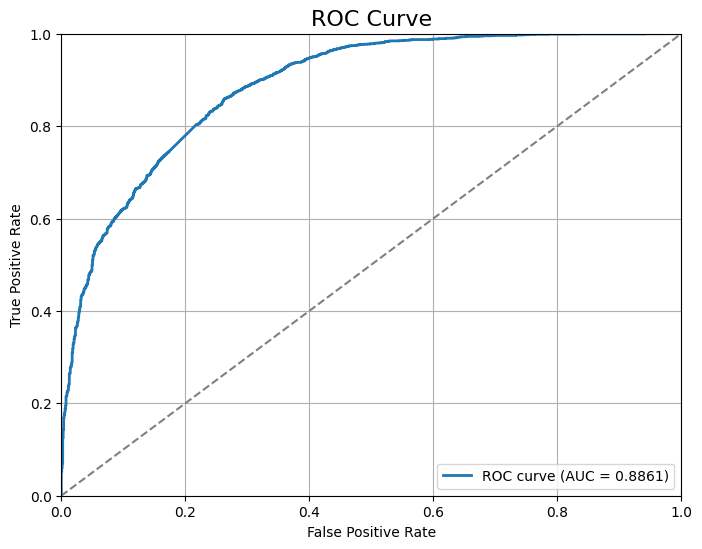

In [ ]:
# Select the best model found during the hyperparameter tuning process
best_model = tuner.get_best_models()[0]

# Generate probabilities for the test set, .ravel() flattens the output to a 1D array, as required by roc_curve
y_scores = best_model.predict(X_test).ravel()

# Compute the false positive rate (fpr), true positive rate (tpr), and thresholds for the ROC curve and then the roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve", fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)

#plt.savefig("/content/drive/MyDrive/MAGIC ML/immagini/roc_cnn_64.png", dpi=300)
plt.show()

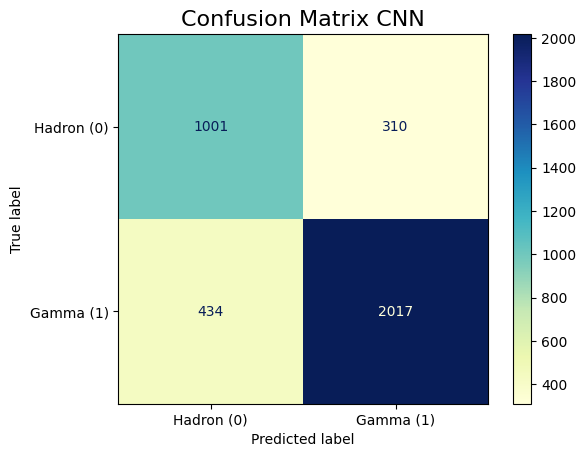

In [ ]:
# Convert predicted probabilities into binary class predictions
y_pred_binary = (y_scores > 0.5).astype(int)

#Compute the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Hadron (0)", "Gamma (1)"])

disp.plot(cmap='YlGnBu')
plt.title("Confusion Matrix CNN", fontsize=16)

#plt.savefig("/content/drive/MyDrive/MAGIC ML/immagini/confusion_matrix_cnn_128.png", dpi=300)
plt.show()

In [ ]:
# Get predicted probabilities and ROC curve
y_scores = best_model.predict(X_test).flatten()
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Find indices where the false positive rate (FPR) is below 5%
low_fpr_idx = np.where(fpr < 0.05)[0]


# Select the threshold with the highest TPR
best_idx = low_fpr_idx[-1]
threshold_01 = thresholds[best_idx]
print(f"\nThreshold selezionato (FPR < 0.05): {threshold_01:.4f}")

# Generate predictions using the selected threshold
y_pred_custom = (y_scores >= threshold_01).astype(int)

# Evaluate precision, recall, and confusion matrix
precision = precision_score(y_test, y_pred_custom)
recall = recall_score(y_test, y_pred_custom)
cm = confusion_matrix(y_test, y_pred_custom)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:\n", cm)

118/118 ━━━━━━━━━━━━━━━━━━━━ 52s 438ms/step

Threshold selezionato (FPR < 0.05): 0.6765
Precision: 0.9497
Recall: 0.5002
Confusion Matrix:
 [[1246   65]
 [1225 1226]]


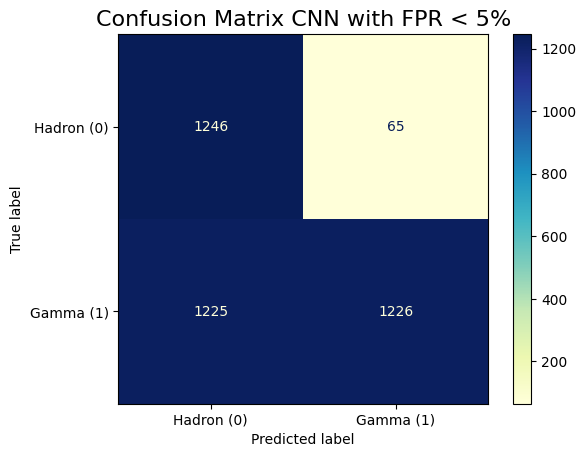

In [ ]:
# Compute the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_custom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Hadron (0)", "Gamma (1)"])

disp.plot(cmap='YlGnBu')
plt.title(f"Confusion Matrix CNN with FPR < 5%", fontsize=16)

#plt.savefig("/content/drive/MyDrive/MAGIC ML/immagini/confusion_matrix_cnn_128_thresh_5.png", dpi=300)
plt.show()

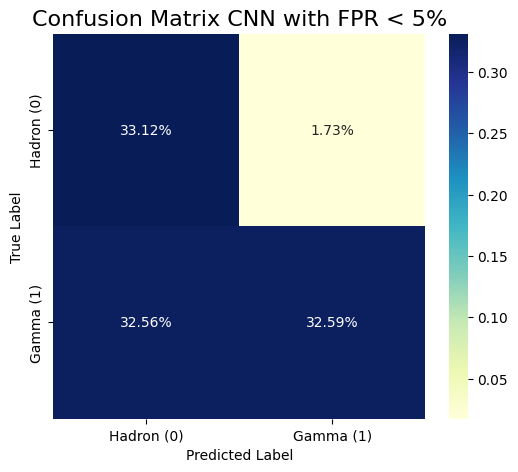

In [ ]:
# Confusion matrix with percentage
cm_normalized = cm / np.sum(cm)
labels = ["Hadron (0)", "Gamma (1)"]

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)

plt.title(f"Confusion Matrix CNN with FPR < 5%", fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#plt.savefig("/content/drive/MyDrive/MAGIC ML/immagini/confusion_matrix_cnn_128_thresh_5_perc.png", dpi=300)
plt.show()

In [ ]:
# Get predicted probabilities and ROC curve
y_scores = best_model.predict(X_test).flatten()
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Find indices where the false positive rate (FPR) is below 5%
low_fpr_idx = np.where(fpr < 0.10)[0]


# Select the threshold with the highest TPR
best_idx = low_fpr_idx[-1]
threshold_01 = thresholds[best_idx]
print(f"\nThreshold selezionato (FPR < 0.10): {threshold_01:.4f}")

# Generate predictions using the selected threshold
y_pred_custom = (y_scores >= threshold_01).astype(int)

# Evaluate precision, recall, and confusion matrix
precision = precision_score(y_test, y_pred_custom)
recall = recall_score(y_test, y_pred_custom)
cm = confusion_matrix(y_test, y_pred_custom)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:\n", cm)

118/118 ━━━━━━━━━━━━━━━━━━━━ 54s 461ms/step

Threshold selezionato (FPR < 0.10): 0.5872
Precision: 0.9208
Recall: 0.6214
Confusion Matrix:
 [[1180  131]
 [ 928 1523]]


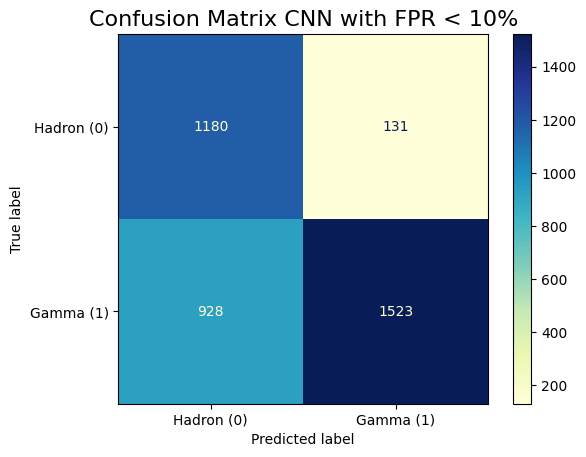

In [ ]:
# Compute the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_custom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Hadron (0)", "Gamma (1)"])

disp.plot(cmap='YlGnBu')
plt.title(f"Confusion Matrix CNN with FPR < 10%", fontsize=16)

#plt.savefig("/content/drive/MyDrive/MAGIC ML/immagini/confusion_matrix_cnn_128_thresh_10.png", dpi=300)
plt.show()

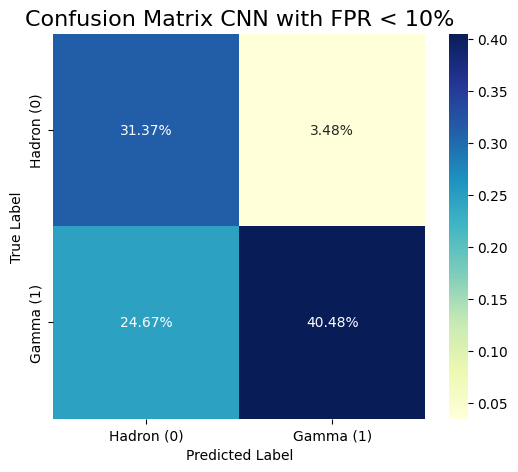

In [ ]:
# Confusion matrix with percentage
cm_normalized = cm / np.sum(cm)
labels = ["Hadron (0)", "Gamma (1)"]

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)

plt.title(f"Confusion Matrix CNN with FPR < 10%", fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#plt.savefig("/content/drive/MyDrive/MAGIC ML/immagini/confusion_matrix_cnn_128_thresh_10_perc.png", dpi=300)
plt.show()